In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
data=pd.read_csv('/content/gdrive/MyDrive/train/train.csv')
data.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [4]:
ship= {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# reverse the ship type dictionary

ship = dict([[v,k] for k,v in ship.items()])
data['Target']=data['category'].map(ship).astype('category')
data.head()

,image,category,Target
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text major ticklabel objects>)

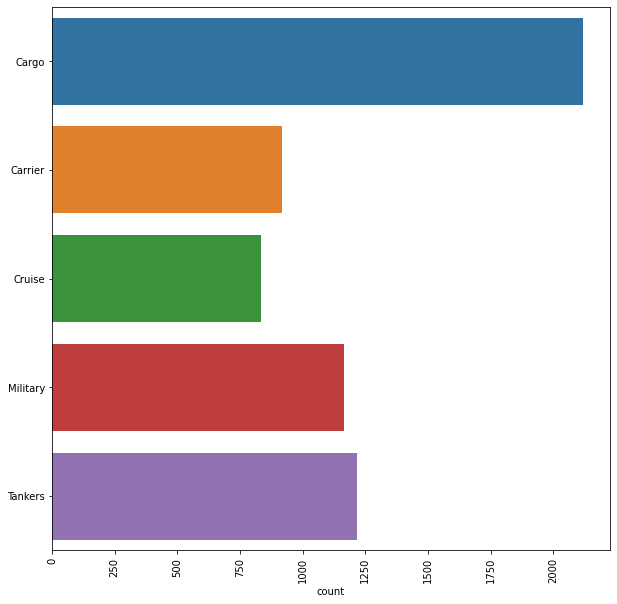

In [6]:
plt.figure(figsize=(10,10))
sns.countplot(y=data['Target'].values)
plt.xticks(rotation=90)

In [7]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(data,test_size=0.25,random_state=42)

In [8]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [10]:
print(train_df.shape)
print(test_df.shape)

(4689, 3)
(1563, 3)


In [11]:
from keras.preprocessing.image import ImageDataGenerator
INPUT_PATH='/content/gdrive/MyDrive/train/images'
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3752 validated image filenames belonging to 5 classes.
Found 937 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


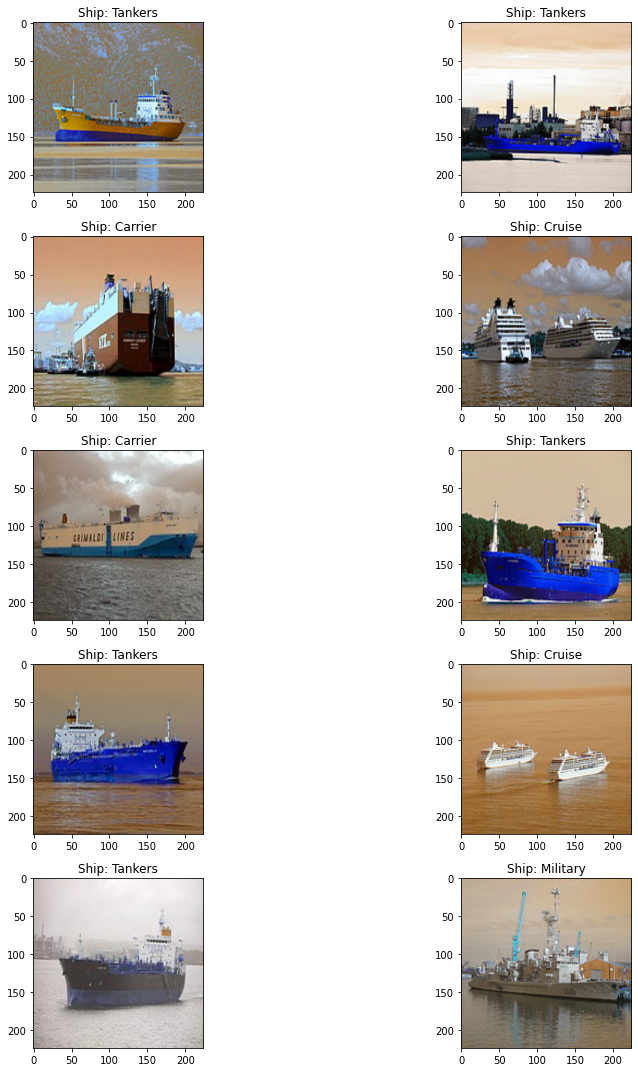

In [12]:
import random as rn
import cv2
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,data.shape[0])
        img = cv2.imread(INPUT_PATH+'/'+data.iloc[l][0],cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        ax[i,j].imshow(img)
        ax[i,j].set_title('Ship: '+data.iloc[l][2])
plt.tight_layout()

#Pretrained EfficentNet

In [13]:
def create_model(input_shape):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [14]:
model=create_model(input_shape=(224,224,3))

27033600/27018416 [==============================] - 0s 0us/step


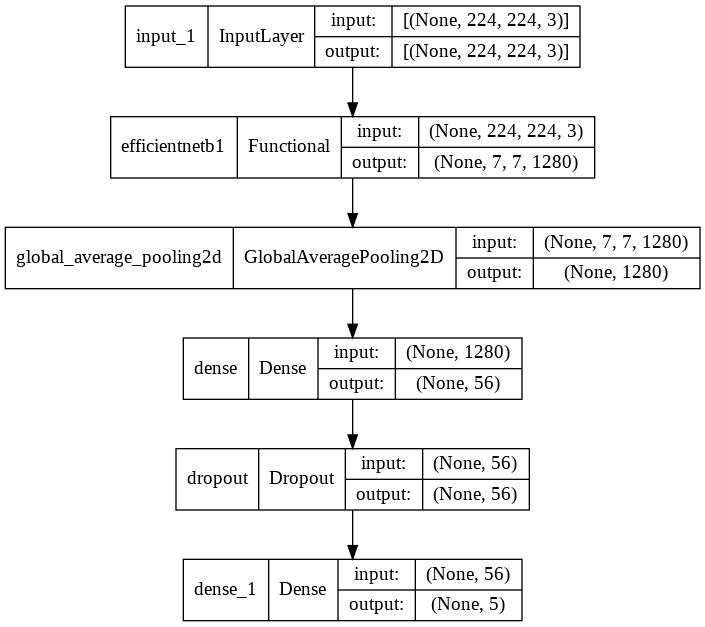

In [15]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [16]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy',f1_score])

In [18]:
from tensorflow.keras.callbacks import *
import os
%reload_ext tensorboard
filepath="/content/gdrive/MyDrive/Flower dataset/"
checkpoint = ModelCheckpoint(monitor='val_f1_score', mode='max', filepath=filepath, verbose=1, save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor = 'val_f1_score',  mode="max",min_delta = 0, patience = 6,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.25, patience = 3, verbose = 1,min_lr=0.000001)
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [reduce_lr,tensorboard,checkpoint,earlystop]

In [20]:
STEP_SIZE_TRAIN=train_images.n//train_images.batch_size
STEP_SIZE_VALID=val_images.n//val_images.batch_size
STEP_SIZE_TEST=test_images.n//test_images.batch_size
history=model.fit_generator(generator=train_images,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_images,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,callbacks=callbacks)

Epoch 1/25
117/117 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.8129 - f1_score: 0.7849
Epoch 00001: val_f1_score improved from -inf to 0.00000, saving model to /content/gdrive/MyDrive/Flower dataset/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Flower dataset/assets
117/117 [==============================] - 1187s 10s/step - loss: 0.5128 - accuracy: 0.8129 - f1_score: 0.7849 - val_loss: 2.0976 - val_accuracy: 0.1347 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/25
117/117 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9272 - f1_score: 0.9231
Epoch 00002: val_f1_score improved from 0.00000 to 0.13470, saving model to /content/gdrive/MyDrive/Flower dataset/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Flower dataset/assets
117/117 [==============================] - 117s 1s/step - loss: 0.2331 - accuracy: 0.9272 - f1_score: 0.9231 - val_loss: 2.6911 - val_accuracy: 0.1347 - val_f1_score: 0.1347 - lr: 0.0010

In [21]:
model.save_weights("/content/gdrive/MyDrive/ships/model.h5")

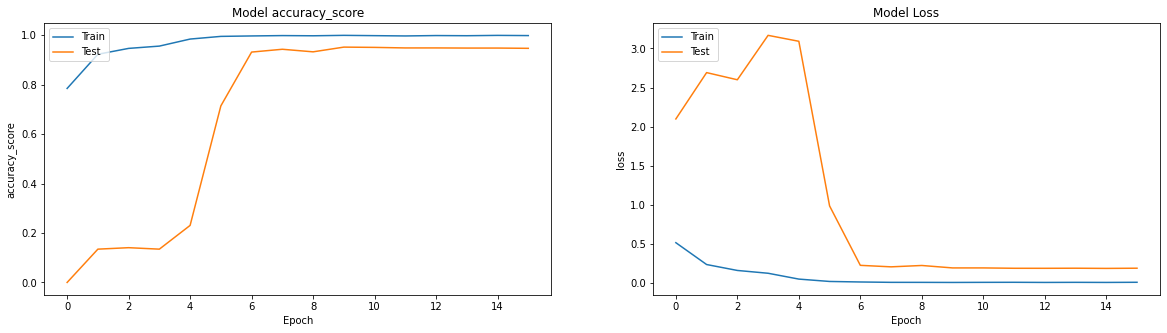

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model accuracy_score')
plt.ylabel('accuracy_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.20776
Test Accuracy: 94.50%


In [25]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [26]:
from sklearn.metrics import classification_report
y_test = list(test_df.Target)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       Cargo       0.92      0.93      0.93       520
     Carrier       0.99      0.97      0.98       239
      Cruise       0.97      0.99      0.98       203
    Military       0.99      0.98      0.98       284
     Tankers       0.90      0.89      0.90       317

    accuracy                           0.94      1563
   macro avg       0.95      0.95      0.95      1563
weighted avg       0.95      0.94      0.95      1563



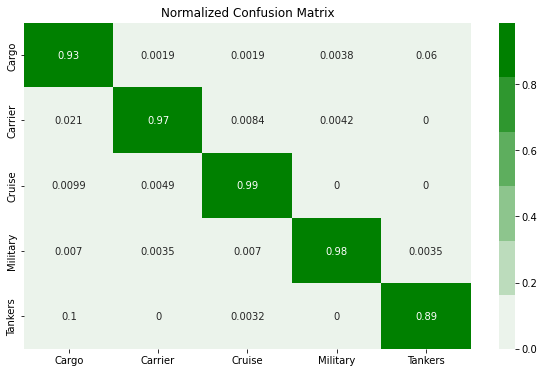

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = list(test_df.Target)
cf_matrix = confusion_matrix(y_test, pred,normalize='true')
plt.figure(figsize = (10,6))
cmap=sns.light_palette("green")
sns.heatmap(cf_matrix,cmap=cmap, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

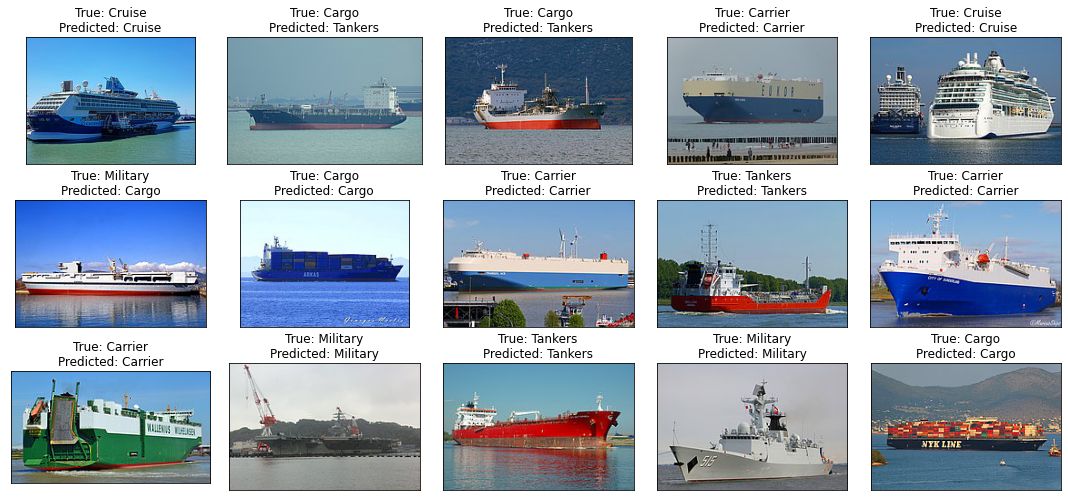

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(INPUT_PATH+'/'+test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.Target.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
# Efficentnet model works Train Accuracy is approx 100% and Test Accuracy 95%.

## Apply Augmentation

In [31]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=(0.8, 1.2),
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=(0.8, 1.2),
)

In [32]:
train_images_aug = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_aug = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_aug = test_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=False
)

Found 3752 validated image filenames belonging to 5 classes.
Found 937 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [33]:
model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy',f1_score])

In [34]:
from tensorflow.keras.callbacks import *
import os
%reload_ext tensorboard
filepath="/content/gdrive/MyDrive/Flower dataset/"
checkpoint = ModelCheckpoint(monitor='val_f1_score', mode='max', filepath=filepath, verbose=1, save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor = 'val_f1_score',  mode="max",min_delta = 0, patience = 6,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.25, patience = 3, verbose = 1,min_lr=0.000001)
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [reduce_lr,tensorboard,checkpoint,earlystop]

In [36]:
STEP_SIZE_TRAIN=train_images.n//train_images.batch_size
STEP_SIZE_VALID=val_images.n//val_images.batch_size
STEP_SIZE_TEST=test_images.n//test_images.batch_size
history=model.fit_generator(generator=train_images,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_images,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,callbacks=callbacks)

Epoch 1/25
117/117 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9930 - f1_score: 0.9925
Epoch 00001: val_f1_score did not improve from 0.63046
117/117 [==============================] - 40s 343ms/step - loss: 0.0207 - accuracy: 0.9930 - f1_score: 0.9925 - val_loss: 2.9645 - val_accuracy: 0.3728 - val_f1_score: 0.3596 - lr: 2.5000e-04
Epoch 2/25
117/117 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9970 - f1_score: 0.9969
Epoch 00002: val_f1_score improved from 0.63046 to 0.87468, saving model to /content/gdrive/MyDrive/Flower dataset/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Flower dataset/assets
117/117 [==============================] - 119s 1s/step - loss: 0.0110 - accuracy: 0.9970 - f1_score: 0.9969 - val_loss: 0.4624 - val_accuracy: 0.8728 - val_f1_score: 0.8747 - lr: 2.5000e-04
Epoch 3/25
117/117 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989 - f1_score: 0.9991
Epoch 00003: val_f1

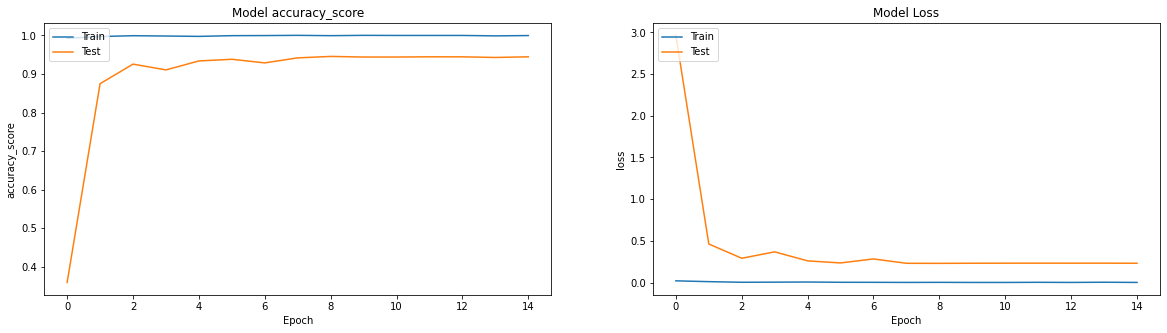

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model accuracy_score')
plt.ylabel('accuracy_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [38]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.24786
Test Accuracy: 94.18%


In [39]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

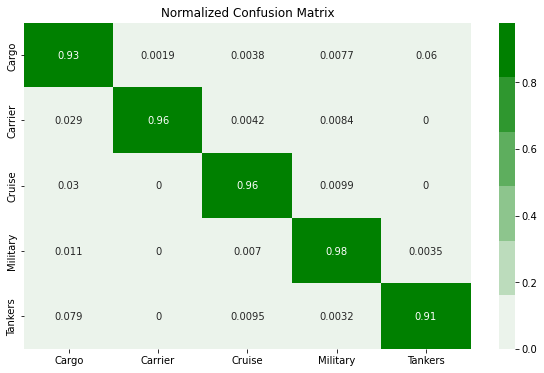

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = list(test_df.Target)
cf_matrix = confusion_matrix(y_test, pred,normalize='true')
plt.figure(figsize = (10,6))
cmap=sns.light_palette("green")
sns.heatmap(cf_matrix,cmap=cmap, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

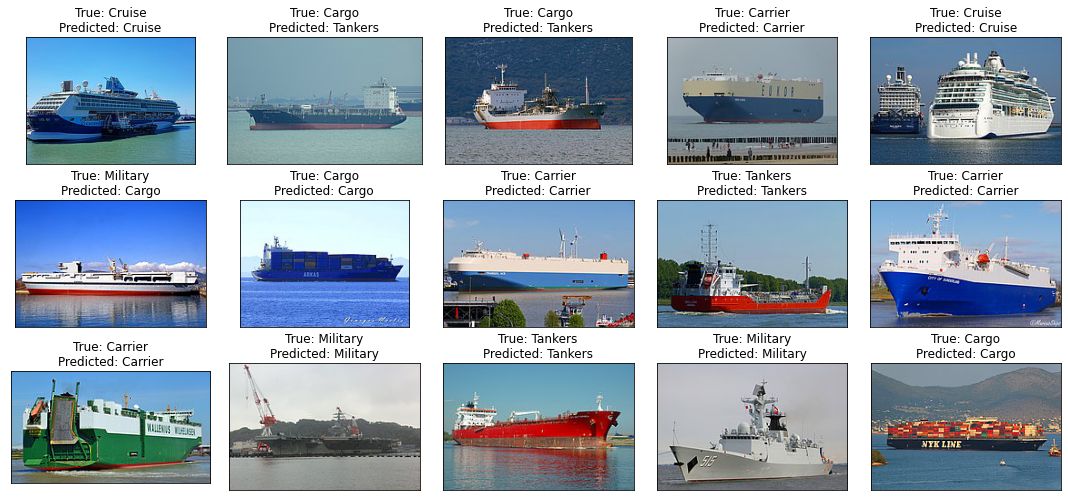

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(INPUT_PATH+'/'+test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.Target.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()